In [5]:
%%writefile /mnt/solexa/mel_yang/bronzeage/jda/jda_calcreads.py

#%%writefile /home/melinda_yang/ivpp/bronzeage/jda_calcreads.py

##Call reads from bam file, aligns to snpfile fed into script
##Needs indexed bam file
import argparse
import pysam


parser = argparse.ArgumentParser("Get counts of reads from bam file")

parser.add_argument("-p", type=str, default="/mnt/solexa/mel_yang/bamfiles/",  help = "bamfile folder, default: /mnt/solexa/mel_yang/bamfiles/")
parser.add_argument("-q", type=str, default="/home/mel_yang/projects/bronzeage/",  help = "snpfile folder, default: /home/mel_yang/projects/bronzeage/")
parser.add_argument("-b", type=str, default="L0554.mapping.sorted.uniq.L35MQ30",  help = "bamfilename, default: L0554.mapping.sorted.uniq.L35MQ30")
parser.add_argument("-s", type=str, default="ind_A_v13_TBH",  help = "snpfilename, default: ind_A_v13_TBH")

args=parser.parse_args()

pD1,pD2,bamfilename,snpfilename=(args.p,args.q,args.b,args.s)

snpdat=[]
snpfile=open(pD2+snpfilename+".snp",'r')
for line in snpfile:
    x=line.split()
    snpdat.append((int(x[1]),int(x[3]),x[4],x[5]))
snpfile.close()
snp1pos = [i[1] for i in snpdat if i[0]==1]

newfilename="jda_"+bamfilename+"_"+snpfilename+".readcount"
newfile=open(pD2+newfilename,'w')

bamfile=pysam.AlignmentFile(pD1+bamfilename+".bam",'rb')
num=0
for ind,snpinfo in enumerate(snpdat):
    #print snpinfo
    #if ind==100: break
    chrom,pos,b1,b2=snpinfo
    b1count,b2count,ocount=0,0,0
    try:
        pileup=bamfile.pileup(str(chrom),pos-1,pos)
        num+=1
    except ValueError:
        newfile.write("%.0f\t%.0f\t%s\t%s\t%d\t%d\t%d\n" % (chrom,pos,b1,b2,b1count,b2count,ocount))
        continue
    #print pileup
    for pileupcolumn in pileup:
        if pileupcolumn.pos != pos: continue
        for pileupread in pileupcolumn.pileups:
            if pileupread.is_del or pileupread.is_refskip: continue
            base = pileupread.alignment.query_sequence[pileupread.query_position-1]
            if base==b1: b1count+=1
            elif base==b2: b2count+=1
            else: ocount+=1
    newfile.write("%.0f\t%.0f\t%s\t%s\t%d\t%d\t%d\n" % (chrom,pos,b1,b2,b1count,b2count,ocount))
newfile.close()
                
#print num    
    

Overwriting /mnt/solexa/mel_yang/bronzeage/jda/jda_calcreads.py


In [12]:
%%writefile /mnt/solexa/mel_yang/bronzeage/jda/jda_getpd_dfreq.py
##Make frequency and read file, oriented by ancestry (allele in chimp)

import collections
import numpy as np
import sys

moderneas=["Daur","Hezhen","Mongola","Naxi","Oroqen","Ulchi","Xibo","Dai","Dong",
          "Gelao","Lahu","Li","Maonan","Miao","Mulam","She","Tujia","Yi","Zhuang",
          "Cambodian","Han_Chongqing","Han_Fujian","Han_Guandong","Han_Henan",
          "Han_HGDP","Han_Hubei","Han_Jiangsu","Han_NChina","Han_Shandong","Han_Shanghai",
          "Han_Shanxi","Han_Sichuan","Han_Zhejiang","Kinh_Vietnam_KHV","Korean","Thai",
          "Qiang_Horpa","Tibetan_Chamdo","Tibetan_Gangcha","Tibetan_Gannan","Tibetan_Lhasa",
          "Tibetan_Nagqu","Tibetan_Shannan","Tibetan_Shigatse","Tibetan_Xinlong",
          "Tibetan_Xunhua","Tibetan_Yajiang","Japanese","Ami_Stoneking","Atayal_Stoneking"]
moderneas=[sys.argv[1]]

pD1="/home/mel_yang/projects/bronzeage/"
pD2="/mnt/solexa/mel_yang/bronzeage/jda/"
indfilename="ind_A_v13_TBH"
indfile=open(pD1+indfilename+".ind",'r')
pdeas=collections.defaultdict(list)
for ind,line in enumerate(indfile):
    x = line.split()
    if x[2] in moderneas: pdeas[x[2]].append(ind)
    if x[2] == "Chimp": ancind=ind ##ONLY 0/2, no heterozygotes
indfile.close()
#print pdeas["Han_HGDP"]
newfile=open(pD2+indfilename+".pdEAS."+'_'.join(pdeas.keys())+".dfreq",'w')
newfile.write('\t'.join([i for i in pdeas])+'\n')

genofile=open(pD1+indfilename+".geno",'r')
num=0
for line in genofile:
    num+=1
    #if num==10: break
    ancgeno=int(line[ancind])
    
    dfreqs=[]
    for indiv in pdeas:
        easgeno=[int(line[ind]) for ind in pdeas[indiv]]
        if 9 in easgeno: dfreqs.append(-5); continue
        total=2.0*(len(easgeno)-easgeno.count(9))
        #if total == 0: dfreqs.append(-5); continue
        secondallele=(np.sum(easgeno)-9*easgeno.count(9))
        if ancgeno==0: mydfreq=secondallele/total
        elif ancgeno==2: mydfreq=1-(secondallele/total)
        else: print "ancgeno is", ancgeno
        dfreqs.append(mydfreq)
        #if indiv=="Han_HGDP": print easgeno, ancgeno, mydfreq,mydfreq*66
    newfile.write('\t'.join(["%.4f" % i for i in dfreqs]) + '\n')
    
newfile.close()

#for i in pdeas: print "%s----------%d" % (i,len(pdeas[i]))
  
    

Overwriting /mnt/solexa/mel_yang/bronzeage/jda/jda_getpd_dfreq.py


In [6]:
%%writefile /mnt/solexa/mel_yang/bronzeage/jda/mergereadcountfiles.py
##Merge readcount files for ancinet individuals
##For some reason, the .geno file shows switched order for SNPs than the .readcount file
##Thus, by using the Chimp genotype call, this is reversed from the .readcount file order
##So we have to switch the two from what logically follows as ancestral/derived calls
##Done below

##030617: Added DHG and BLK (7 indivs total)

pD2="/mnt/solexa/mel_yang/bronzeage/jda/"
readcountfilenames=["jda_L0554.mapping.sorted.uniq.L35MQ30_ind_A_v13_TBH.readcount",
    "jda_R2039.rd_ind_A_v13_TBH.readcount",
    "jda_R2142.rd_ind_A_v13_TBH.readcount",
    "jda_L0597.mapping.sorted.uniq.L35MQ30_ind_A_v13_TBH.readcount",
    "jda_R2096.rd_ind_A_v13_TBH.readcount",
    "jda_R2148.rd_ind_A_v13_TBH.readcount",
    "jda_R2038.rd_ind_A_v13_TBH.readcount",
    "jda_R2099.rd_ind_A_v13_TBH.readcount",
    "jda_TY_ind_A_v13_TBH.readcount",
    "jda_dong_M11_rg.fixchr_ind_A_v13_TBH.readcount", ##new indivs DHG/BLK start
    "jda_dong_M12_rg.fixchr_ind_A_v13_TBH.readcount",
    "jda_dong_M819_rg.fixchr_ind_A_v13_TBH.readcount",
    "jda_dong_M820_rg.fixchr_ind_A_v13_TBH.readcount",
    "jda_dong_M827_rg.fixchr_ind_A_v13_TBH.readcount",
    "jda_dong_M9JM6-1_rg.fixchr_ind_A_v13_TBH.readcount",
    "jda_L0729.mapping.sorted.uniq.L35MQ30_ind_A_v13_TBH.readcount",
    "jda_D1965.un15,niq.L30MQ0_ind_A_v13_TBH.readcount",
    "jda_D1968.un15,niq.L30MQ0_ind_A_v13_TBH.readcount",
    "jda_D5602.uniq.L30MQ0_ind_A_v13_TBH.readcount",
    "jda_D5604.uniq.L30MQ0_ind_A_v13_TBH.readcount",
    "jda_D5605.uniq.L30MQ0_ind_A_v13_TBH.readcount",
    "jda_D5607.uniq.L30MQ0_ind_A_v13_TBH.readcount",
    "jda_D5608.uniq.L30MQ0_ind_A_v13_TBH.readcount"]

chimpfile=open(pD2+"Chimp.geno",'r')
chimpgeno=chimpfile.readlines()
chimpfile.close()
readcountfiles=[open(pD2+i,'r') for i in readcountfilenames]

newfile=open(pD2+"jda_anceas_switchanc.readcount",'w')
newfile2=open(pD2+"jda_anceas_switchanc.chrompos",'w')
newfile2.write('Chrom\tPos\n')
for i in readcountfilenames:
    if "dong" in i: myname=i.split('.')[0].split('_')[2]
    else: myname=i.split('.')[0].split('_')[1]
    newfile.write("%s_der\t%s_anc\t%s_other\t" % tuple([myname]*3))
newfile.write('\n')
num=0
for chimpline in chimpgeno:
    ancgeno=chimpline.strip()
    #print ancgeno
    mycounts=[]
    for ind,readcountfile in enumerate(readcountfiles):
        myreadline=readcountfile.readline()
        #print myreadline.strip()
        mylst=myreadline.split()
        if ind==0: beg="\t".join(mylst[:2])
        mylst=mylst[4:]
        if ancgeno=='0': mycounts+=mylst ##THIS IS WRONG??? IF ANCGENO is 2, then that means second column is ancestral, so
        elif ancgeno=='2': 
            mylst[0],mylst[1]=mylst[1],mylst[0]
            mycounts+=mylst
        else: print 'bad ancgeno',ancgeno
    #print len(mycounts)
    #print mycounts
    #break
    newfile.write('\t'.join(mycounts)+'\n')
    newfile2.write(beg+'\n')
newfile2.close()
newfile.close()

Overwriting /mnt/solexa/mel_yang/bronzeage/jda/mergereadcountfiles.py


In [23]:
%%bash
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
addon="_switchanc"
for myref in Han_HGDP Japanese Ulchi Zhuang Dong Qiang_Horpa Tibetan_Gangcha Thai Maonan Mulam Tibetan_Chamdo She Dai Yi Tujia Miao; 
do
    paste ${pD}jda_anceas${addon}.chrompos ${pD}ind_A_v13_TBH.pdEAS.${myref}.dfreq ${pD}jda_anceas${addon}.readcount > ${pD}jda_anceas${addon}_${myref}.comb
    head -n1 ${pD}jda_anceas${addon}_${myref}.comb > ${pD}jda_anceas${addon}_${myref}_nomissfixed.header
    cat ${pD}jda_anceas${addon}_${myref}.comb | grep -v "-" | grep -v "0.0000" | grep -v "1.0000" > ${pD}jda_anceas${addon}_${myref}_nomissfixed.comb1
    cat ${pD}jda_anceas${addon}_${myref}_nomissfixed.header ${pD}jda_anceas${addon}_${myref}_nomissfixed.comb1 > ${pD}jda_anceas${addon}_${myref}_nomissfixed.comb
    rm ${pD}jda_anceas${addon}_${myref}_nomissfixed.comb1
    rm ${pD}jda_anceas${addon}_${myref}_nomissfixed.header
    rm ${pD}jda_anceas${addon}_${myref}.comb
done

In [35]:
print ' '.join(["Han_HGDP","Japanese","Ulchi","Zhuang","Dong","Qiang_Horpa","Tibetan_Gangcha",
        "Thai","Maonan","Mulam","Tibetan_Chamdo","She","Dai","Yi","Tujia","Miao"])

Han_HGDP Japanese Ulchi Zhuang Dong Qiang_Horpa Tibetan_Gangcha Thai Maonan Mulam Tibetan_Chamdo She Dai Yi Tujia Miao


In [7]:
%%writefile /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_sepZGMYJ.py
from ancient_genotypes import *
from numpy import *
import pandas
import cPickle
addon="_switchanc"
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
myrefs=["Han_HGDP","Japanese","Ulchi","Zhuang","Dong","Qiang_Horpa","Tibetan_Gangcha",
        "Thai","Maonan","Mulam","Tibetan_Chamdo","She","Dai","Yi","Tujia","Miao"]
for myref in myrefs:
    freq, reads, inds = parse_reads(pD+"jda_anceas"+addon+"_"+myref+"_nomissfixed.comb",cutoff=0)
    ##Tonglin, Linzi, XianShang, Yaojia/ZGM, TY, DHG, BLK, XSQ, ZGM
    pops=[[0],[1,6,7],[2,5],[3],[4],[8],[9,10,11,12,13,14],[15],[16,17,18],[19,20,21,22]]
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=8,continuity=False)
    cPickle.dump(params_pops,open(pD+"ind_A_v13_TBH"+addon+"."+myref+"_contFalse.pickle","w"))
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=8,continuity=True)
    cPickle.dump(params_pops,open(pD+"ind_A_v13_TBH"+addon+"."+myref+"_contTrue.pickle","w"))

Overwriting /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_sepZGMYJ.py


In [23]:
%%writefile /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_sepDHG.py
from ancient_genotypes import *
from numpy import *
import pandas
import cPickle
myref="Japanese"
addon="_switchanc"
addon2="_sepDHG"
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
myrefs=["Han_HGDP","Japanese","Ulchi","Zhuang","Dong","Qiang_Horpa","Tibetan_Gangcha",
        "Thai","Maonan","Mulam","Tibetan_Chamdo","She","Dai","Yi","Tujia","Miao"]
for myref in myrefs:
    freq, reads, inds = parse_reads(pD+"jda_anceas"+addon+"_"+myref+"_nomissfixed.comb",cutoff=0)
    ##Tonglin, Linzi, XianShang, Yaojia/ZGM, TY, DHG, DHG, BLK
    pops=[[0],[1,6,7],[2,5],[3],[4],[8],[9,10,11,12,13],[14],[15]]
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=9,continuity=False)
    cPickle.dump(params_pops,open(pD+"ind_A_v13_TBH"+addon+addon2+"."+myref+"_contFalse.pickle","w"))
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=9,continuity=True)
    cPickle.dump(params_pops,open(pD+"ind_A_v13_TBH"+addon+addon2+"."+myref+"_contTrue.pickle","w"))

Overwriting /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_sepDHG.py


In [3]:
myrefs=["Han_HGDP","Japanese","Ulchi","Zhuang","Dong","Qiang_Horpa","Tibetan_Gangcha",
        "Thai","Maonan","Mulam","Tibetan_Chamdo","She","Dai","Yi","Tujia","Miao"]
        ##"Mongola","Li","Xibo","Oroqen","Naxi","Hezhen","Cambodian", (<10)
myss=[0 for i in myrefs]
pd="/home/mel_yang/projects/bronzeage/"
indfile=open(pd+"ind_A_v13_TBH.ind",'r')
for line in indfile:
    x=line.split()
    if x[2] in myrefs: myss[myrefs.index(x[2])]+=1
for ind,i in enumerate(myrefs): 
    print i, myss[ind]
print myss

Han_HGDP 33
Japanese 29
Ulchi 25
Zhuang 22
Dong 20
Qiang_Horpa 20
Tibetan_Gangcha 20
Thai 19
Maonan 17
Mulam 17
Tibetan_Chamdo 12
She 10
Dai 10
Yi 10
Tujia 10
Miao 10
[33, 29, 25, 22, 20, 20, 20, 19, 17, 17, 12, 10, 10, 10, 10, 10]


In [20]:
%%writefile /mnt/solexa/mel_yang/bronzeage/jda/jda_getcovg.py

import numpy as np

pD2="/mnt/solexa/mel_yang/bronzeage/jda/"
readcountfilenames=["jda_anceas_switchanc.readcount"]
readcountfiles=[open(pD2+i,'r') for i in readcountfilenames]
for ind0,myfile in enumerate(readcountfiles):
    for ind,line in enumerate(myfile):
        if line[0] == "L": continue
        x=line.split()
        if ind==1: myreadcount=np.array([int(i) for i in x[4:]])
        else: myreadcount=np.vstack((myreadcount,np.array([int(i) for i in x[4:]])))
        #if ind==1000: break
    mytotalreads=float(np.sum(myreadcount))
    covg=mytotalreads/myreadcount.shape[0]
    print readcountfilenames[ind0].split('.')[0].split('_')[1], covg
    #break

Writing /mnt/solexa/mel_yang/bronzeage/jda/jda_getcovg.py


8
_______________________
Han_HGDP
False Tonglin 51910.1493392 [0.0093266093093476599, 0.12419034308057428, 0.015146734333202964]
True Tonglin 51940.9099078 [0.014158745373700753, 0.011087114687408795]
_______________________
Japanese
False Tonglin 50497.6421797 [0.016611503334613902, 0.16409868441067049, 0.019824838135874309]
True Tonglin 50543.3962708 [0.022723638779064179, 0.014164432388940062]
_______________________
Ulchi
False Tonglin 53390.3702048 [0.033388319589140236, 0.30183426493508725, 0.032359371150972413]
True Tonglin 53511.2470587 [0.043437337201629109, 0.021814513414984998]
_______________________
Zhuang
False Tonglin 53610.5589765 [0.019756373130967321, 0.17640958143117533, 0.021763871614939027]
True Tonglin 53663.6210344 [0.026572925076223053, 0.015328635289020792]
_______________________
Dong
False Tonglin 53507.6347105 [0.019388370061227459, 0.18421967010429727, 0.021936920142008324]
True Tonglin 53564.3022831 [0.026516635339369883, 0.015049756137450614]
___________

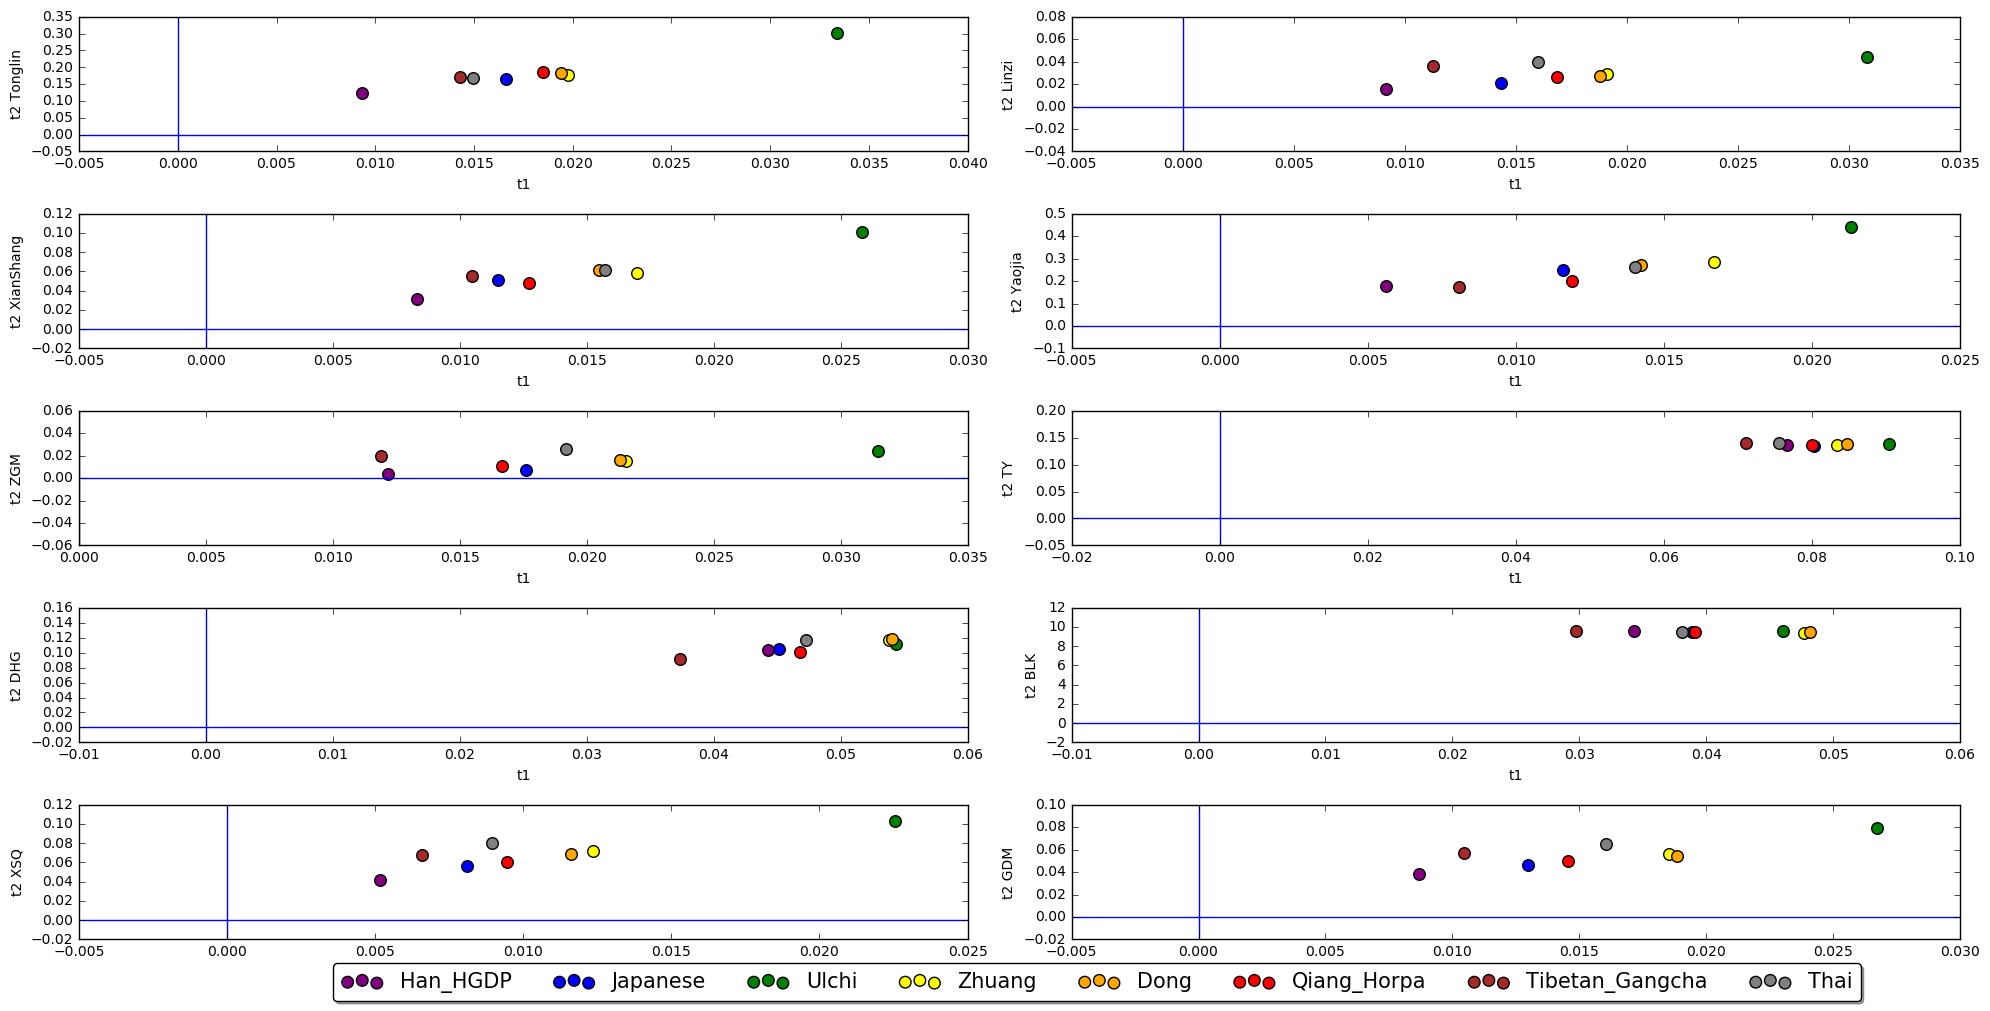

In [21]:
%matplotlib inline

import cPickle
import matplotlib.pyplot as plt
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
addon="_switchanc"
refpops=["Han_HGDP","Japanese","Ulchi","Zhuang","Dong","Qiang_Horpa","Tibetan_Gangcha",
        "Thai"] #,"Maonan","Mulam","Tibetan_Chamdo","She","Dai","Yi","Tujia","Miao"]
        ##"Mongola","Li","Xibo","Oroqen","Naxi","Hezhen","Cambodian", (<10)
print len(refpops)
#refpops=["Han_HGDP"]
mypops=["Tonglin", "Linzi", "XianShang", "Yaojia","ZGM", "TY","DHG","BLK","XSQ","GDM"]
popiwant="TY"
fig = plt.figure(figsize=(20,10))
for myind,popiwant in enumerate(mypops):
    #if myind>5: continue
    ax = fig.add_subplot(5,2,myind+1)
    t1f,t2f,t1t,t2t=[],[],[],[]
    for refpop in refpops:
        print "_______________________"
        print refpop
        falsefile=open(pD+"ind_A_v13_TBH"+addon+"."+refpop+"_contFalse.pickle",'r')
        falsedat=cPickle.load(falsefile)
        truefile=open(pD+"ind_A_v13_TBH"+addon+"."+refpop+"_contTrue.pickle",'r')
        truedat=cPickle.load(truefile)
        #print falsedat

        for ind,mypop in enumerate(falsedat):
            #if ind in [0,2,3,4]: continue
            #if ind in [0,1,2,3]: continue
            if mypops[ind] == popiwant:
                print "False", mypops[ind],mypop[1], list(mypop[0])
                print "True", mypops[ind],truedat[ind][1],list(truedat[ind][0])
                t1f.append(mypop[0][0])
                t2f.append(mypop[0][1])
                t1t.append(truedat[ind][0][0])
                t2t.append(truedat[ind][0][1])


    colors=["purple","blue","green","yellow","orange","red","brown",
            "gray","black","lavender","fuchsia","goldenrod","peachpuff","cyan",
            "lawngreen","mediumslateblue","cadetblue","pink","tan","lavenderblush",
            "sage","peru","gainsboro"]
    #print t1f
    for i in range(len(t1f)):
        #handles.append(ax.scatter(t1f[i],t2f[i],c=colors[i],label=refpops[i]))
        ax.scatter(t1f[i],t2f[i],label=refpops[i],c=colors[i],s=70)
    
    #ax.set_xlim((0,0.13))
    #ax.set_ylim((0,0.35))
    ax.set_xlabel("t1")
    ax.set_ylabel("t2 "+popiwant)
    ax.axhline(y=0)
    ax.axvline(x=0)
ax.legend(fontsize=15,bbox_to_anchor=(0.9, -0.1),ncol=8, fancybox=True, shadow=True)
fig.tight_layout()

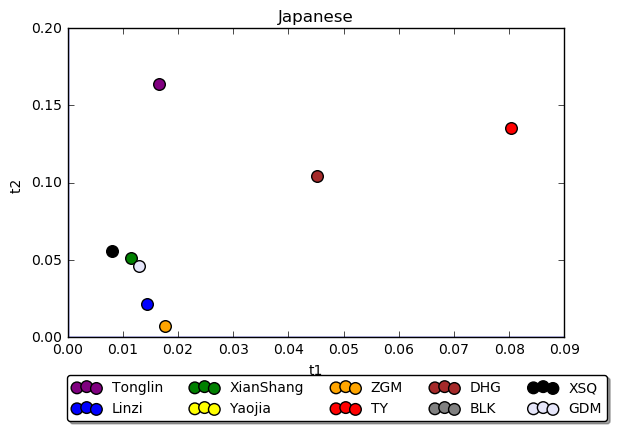

In [82]:
%matplotlib inline
##Plot figure for each reference, showing all ancient
import cPickle
import numpy as np
import matplotlib.pyplot as plt
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
addon="_switchanc"
colors=["purple","blue","green","yellow","orange","red","brown",
            "gray","black","lavender","fuchsia","goldenrod","peachpuff","cyan",
            "lawngreen","mediumslateblue"]
myrefs=["Han_HGDP","Japanese","Ulchi","Zhuang","Dong","Qiang_Horpa","Tibetan_Gangcha",
        "Thai","Maonan","Mulam","Tibetan_Chamdo","She","Dai","Yi","Tujia","Miao"]
refpop="Japanese"
myreps=100
mypops=["Tonglin", "Linzi", "XianShang", "Yaojia","ZGM", "TY","DHG","BLK","XSQ","GDM"]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

falsefile=open(pD+"ind_A_v13_TBH"+addon+"."+refpop+"_contFalse.pickle",'r')
falsedat=cPickle.load(falsefile)
truefile=open(pD+"ind_A_v13_TBH"+addon+"."+refpop+"_contTrue.pickle",'r')
truedat=cPickle.load(truefile)

t1f,t2f,t1t,t2t=[],[],[],[]
for ind,mypop in enumerate(falsedat):
    #if ind!=4: continue
    #print mypops[ind], mypop[0]
    t1f.append(mypop[0][0])
    t2f.append(mypop[0][1])
    t1t.append(truedat[ind][0][0])
    t2t.append(truedat[ind][0][1])
    ax.scatter(mypop[0][0],mypop[0][1],label=mypops[ind],c=colors[ind],s=70)
        
ax.set_title(refpop)
#ax.set_xlim((0,0.13))
ax.set_ylim((0,0.2))
ax.set_xlabel("t1")
ax.set_ylabel("t2 ")
ax.legend(fontsize=10,bbox_to_anchor=(1.1, -0.1),ncol=5, fancybox=True, shadow=True)
ax.axhline(y=0)
ax.axvline(x=0)
fig.tight_layout()

In [85]:
%%writefile /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_bootstrap.py
##Bootstrap replicates
from ancient_genotypes import *
from numpy import *
import pandas
import cPickle
import random

##Tonglin, Linzi, XianShang, Yaojia/ZGM, TY, DHG, BLK, XSQ, ZGM
pops=[[0],[1,6,7],[2,5],[3],[4],[8],[9,10,11,12,13,14],[15],[16,17,18],[19,20,21,22]]
reps=100
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
addir="bootstrap_Han_SChina.ss30/"
fh="jda_anceas_switchanc_Han_HGDP"
fh="jda_anceas_switchanc_manualpdeasmerge_Han_SChina.ss30"
mainfile=open(pD+fh+"_nomissfixed.comb",'r')
header=mainfile.readline()
mainlines=[line for line in mainfile]
mainfile.close()
for i in range(reps):
    print i
    newfile=open(pD+addir+fh+"_rep"+str(i)+".comb",'w')
    newfile.write(header)
    for j in mainlines: newfile.write(random.choice(mainlines))
    newfile.close()
    freq, reads, inds = parse_reads(pD+addir+fh+"_rep"+str(i)+".comb",cutoff=0)
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=8,continuity=False)
    cPickle.dump(params_pops,open(pD+addir+fh+"_rep"+str(i)+"_contFalse.pickle","w"))
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=8,continuity=True)
    cPickle.dump(params_pops,open(pD+addir+fh+"_rep"+str(i)+"_contTrue.pickle","w"))



Overwriting /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_bootstrap.py


Tonglin [ 0.00932661  0.12419034  0.01514673] 0.00494908263615 0.0374446699063
Linzi [ 0.00914486  0.01553745  0.00966205  0.02056481  0.00900628] 0.00136785493864 0.00267881971197
XianShang [ 0.0083093   0.03112091  0.02145641  0.01659116] 0.00458307432338 0.0187150622113
Yaojia [ 0.00560004  0.1770574   0.01709567] 0.0067234403583 7.99844028256
ZGM [ 0.01217419  0.00321821  0.00668225] 0.00193188948504 0.00531168856428
TY [ 0.07664754  0.13588639  0.00477336] 0.00260910550495 0.00602055595164
DHG [ 0.04431202  0.10384874  0.0415765   0.02893381  0.04872141  0.06380197
  0.04376927  0.03236265] 0.00209181454898 0.00480761236772
BLK [ 0.03430498  9.52411991  0.07059754] 0.0105520202372 0.227783195969
XSQ [ 0.0051757   0.0412285   0.02395048  0.01873613  0.02791356] 0.00378270166058 0.0122796218186
GDM [ 0.00867064  0.03830464  0.01581396  0.01544065  0.02500865  0.02430757] 0.00225959066888 0.00413261610441


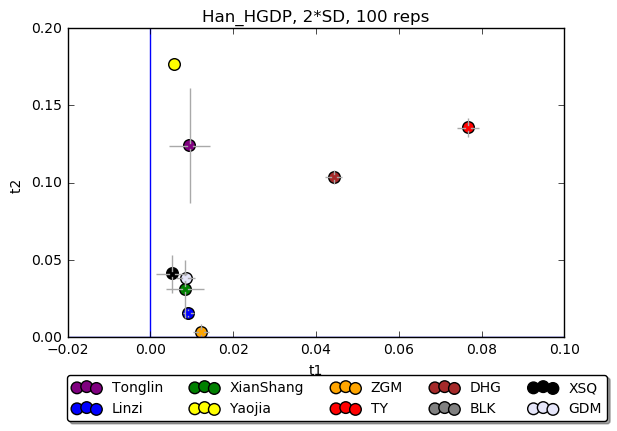

In [79]:
%matplotlib inline

import cPickle
import numpy as np
import matplotlib.pyplot as plt
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
addon="_switchanc"
bootstrapdir="bootstrap_Han_HGDP/"
colors=["purple","blue","green","yellow","orange","red","brown",
            "gray","black","lavender","fuchsia","goldenrod","peachpuff","cyan",
            "lawngreen","mediumslateblue"]
refpop="Han_HGDP"
myreps=100
mypops=["Tonglin", "Linzi", "XianShang", "Yaojia","ZGM", "TY","DHG","BLK","XSQ","GDM"]

for rep in range(myreps):
    falsefile=open(pD+bootstrapdir+"jda_anceas"+addon+"_"+refpop+"_rep"+str(rep)+"_contFalse.pickle",'r')
    falsedat=cPickle.load(falsefile)
    t1ary=np.array([mypop[0][0] for mypop in falsedat])
    t2ary=np.array([mypop[0][1] for mypop in falsedat])
    if rep==0: t1bsary=t1ary; t2bsary=t2ary
    else: 
        t1bsary=np.vstack((t1bsary,t1ary))
        t2bsary=np.vstack((t2bsary,t2ary))
t1mean=t1bsary.mean(axis=0)
t2mean=t2bsary.mean(axis=0)
t1sd=2*t1bsary.std(axis=0)
t2sd=2*t2bsary.std(axis=0)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

falsefile=open(pD+"ind_A_v13_TBH"+addon+"."+refpop+"_contFalse.pickle",'r')
falsedat=cPickle.load(falsefile)
truefile=open(pD+"ind_A_v13_TBH"+addon+"."+refpop+"_contTrue.pickle",'r')
truedat=cPickle.load(truefile)


t1f,t2f,t1t,t2t=[],[],[],[]
for ind,mypop in enumerate(falsedat):
    #if ind!=4: continue
    print mypops[ind], mypop[0],t1sd[ind],t2sd[ind]
    t1f.append(mypop[0][0])
    t2f.append(mypop[0][1])
    t1t.append(truedat[ind][0][0])
    t2t.append(truedat[ind][0][1])
    ax.scatter(mypop[0][0],mypop[0][1],label=mypops[ind],c=colors[ind],s=70)
    if t1sd[ind] < 0.5 and t2sd[ind] < 0.5: 
        ax.errorbar(t1mean[ind],t2mean[ind],xerr=t1sd[ind],yerr=t2sd[ind],ecolor="darkgrey",color=colors[ind],fmt='.',capthick=0,linewidth=1)
        
ax.set_title(refpop+", 2*SD, 100 reps")
#ax.set_xlim((0,0.13))
ax.set_ylim((0,0.2))
ax.set_xlabel("t1")
ax.set_ylabel("t2 ")
ax.legend(fontsize=10,bbox_to_anchor=(1.1, -0.1),ncol=5, fancybox=True, shadow=True)
ax.axhline(y=0)
ax.axvline(x=0)
fig.tight_layout()